In [8]:
from fastai.vision.all import*
from fastai.vision.widgets import *
import numpy as np
import pandas as pd

import random
import os

Data Cleaning

In [9]:
dataSet=pd.read_csv("D:\corizo\data science\data\clothes\images.csv")
dataSet.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


The 'image' column contains the names of the images. This will be mapped to the folder they are stored at to access them while creating the model. The 'label' column identifies the piece of clothing whereas the 'kids' column identifies if the clothing is for children or not.



In [10]:
dataSet['label'].value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

Add suffix '.jpg' to all image files in the dataframe to open them within the model.Keep only the images and their labels for the model to process.

In [11]:
dataSet['image']=dataSet['image']+'.jpg'
data=dataSet[['image','label']]
data.head()

,image,label
0,4285fab0-751a-4b74-8e9b-43af05deee22.jpg,Not sure
1,ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg,T-Shirt
2,00627a3f-0477-401c-95eb-92642cbe078d.jpg,Not sure
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg,T-Shirt
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg,Shoes


In [12]:
data['image']

0       4285fab0-751a-4b74-8e9b-43af05deee22.jpg
1       ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg
2       00627a3f-0477-401c-95eb-92642cbe078d.jpg
3       ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg
4       3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg
                          ...                   
5398    dfd4079d-967b-4b3e-8574-fbac11b58103.jpg
5399    befa14be-8140-4faf-8061-1039947e329d.jpg
5400    5379356a-40ee-4890-b416-2336a7d84061.jpg
5401    65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg
5402    32b99302-cec7-4dec-adfa-3d4029674209.jpg
Name: image, Length: 5403, dtype: object

Replace 'Not sure' with 'Not_sure'.

In [13]:
dataSet.loc[dataSet['label']=='Not sure','label']='Not_sure'

Merge the two lables 'label' and 'kids' into one column using space as a delimiter.

In [14]:
dataSet['label_cat']=dataSet['label']+' '+dataSet['kids'].astype(str)

Keep only the images and their labels for the model to process.

In [15]:
df=dataSet[['image','label_cat']]

Remove corrupted images from the data set

In [16]:
import PIL
from pathlib import Path 
from PIL import UnidentifiedImageError



In [17]:
TrainDir='D:\corizo\data science\data\clothes'
def get_x(r): return TrainDir + '/clothes_images/' + r['image']
def get_y(r): return r['label_cat'].split(' ')

In [18]:
path=Path(TrainDir).rglob("*.jpg")
for img_p in path:
    try:
        img=PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
        print(img_p)



D:\corizo\data science\data\clothes\clothes_images\040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg
D:\corizo\data science\data\clothes\clothes_images\1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
D:\corizo\data science\data\clothes\clothes_images\784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg
D:\corizo\data science\data\clothes\clothes_images\b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg
D:\corizo\data science\data\clothes\clothes_images\c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
D:\corizo\data science\data\clothes\clothes_images\d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg


In [19]:
corrupted=['040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg','1d0129a1-f29a-4a3f-b103-f651176183eb.jpg','784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg','b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg','c60e486d-10ed-4f64-abab-5bb698c736dd.jpg','d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg']

In [20]:
data=dataSet.drop(dataSet[dataSet['image'].isin(corrupted)].index,axis=0)

## Preprocessing

Now that the dataframe is cleaned and ready to develop the model, it has to be transformed in a way that can be used to create the model. We are using FastAIs Convolusional Neural Network classifier 'resnet18'. This CNN has 18 layers with pretrained weights.


The input to create the learner is a dataloader and the model 'resnet18'. The learner uses 'accuracy_multi', which calculates the accuracy for a multi-category dataset using a specified threshold. The threshold by default is 0.5, but for this model, we can start at 0.2 and then test the outcome of other threshold values.


To create the dataloader, we need to have a DataBlock that will identify the dependent (labels) and the independent (images) variables using the MultiCategoryBlock and ImageBlock respectively. Using ImageBlock will help open the image and convert to a tensor, while MultiCategoryBlock will help with the multilabel classification.


Create functions that will be used to open the images and get the categories of the image for the DataBlock.

In [21]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                  get_x = get_x, get_y = get_y,
                  item_tfms = RandomResizedCrop(128, min_scale=0.35))  # ensure every item is of the same size
dls = dblock.dataloaders(data) # collates items from dataset into minibatches

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


We can view the dataloader images and their subsequent labels.

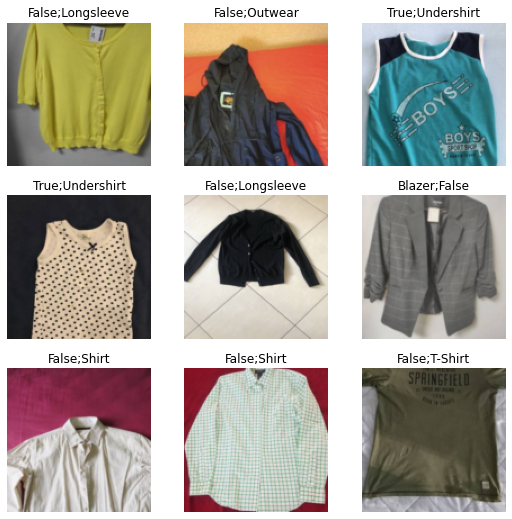

In [22]:
dls.show_batch(nrows=3,ncols=3)

### Create the Learner

Now that the DataLoader is ready, we can now create the learner with the threshold 0.2.

In [23]:
learn = vision_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(5, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.800578,0.341782,0.481717,04:06


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.329511,0.172662,0.887480,05:38
1,0.188583,0.109734,0.958884,06:03
2,0.131373,0.097617,0.960949,05:42
3,0.104561,0.090684,0.962929,05:55
4,0.093354,0.089432,0.963687,05:44


Using 5 epocs, we trained the last layer of the CNN with 18 layers and used the learning rate of 0.003. The 'fine_tune' function uses one epoch to train the final layer on the CNN and then unfreezes the entire model and trains all the 18 layers. With 5 epochs, we have been able to gain a training accuracy of 96.48%.

Now that the learner has been created, we can test different threshold values on the validation set to find the right value to predict the labels.

In [24]:
pred,targ=learn.get_preds()

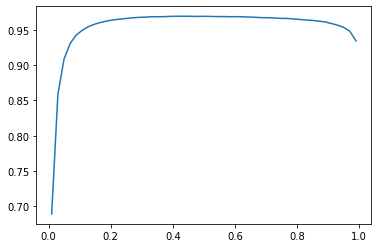

In [25]:
xs=torch.linspace(.01,0.99,50)
accs=[accuracy_multi(pred,targ,thresh=i,sigmoid=False) for i in xs]
plt.plot(xs,accs);

The predictictions are high at the threshold value of 0.1 and above. The smoothness of the curve until what seems to be 0.9 shows that we wont be overfitting by picking a random value. Thus maintaining the threshold at 0.2 should result in non-biased predictions.

The learner can exported to deploy it on a server for an application. Run this notebook on JupyterNotebook server to use the following command to download the model as a .pkl file to the home directory.

In [26]:
learn.export(Path("D:/corizo/data science/data/export.pkl"))

This model will be stored in the home directory. To import it into you new application use 'load_learner(export.pkl)'

### Test The Model
As mentioned above, the model is ready to be imported to a server for an end-to-end application. Although the model can be tested using iPython widgets. We can create a mini interface to upload images and classify them accordingly.

In [27]:
upload = widgets.FileUpload()
out_image = widgets.Output()
prediction = widgets.Label()
run = widgets.Button(description='Classify')


In [28]:
def on_click_classify(change):
    img = PILImage.create(upload.data[-1])
    out_image.clear_output()
    with out_image: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    pred0 = pred[0]
    pred1 = pred[1]
    if pred0=='False':
        prediction.value = f'This is a {pred1} for adults.'
    else:
        prediction.value = f'This is a {pred1} for kids.'

run.on_click(on_click_classify)

In [29]:
VBox([widgets.Label('Upload a picture of a pice of clothing!'), 
      upload, run, out_image, prediction])